## General functionality of MC Dropout

In [1]:
%load_ext autoreload

In [5]:
import os, sys, importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULE_PATH = os.path.join(BASE_PATH, "modules")
DATASET_PATH = os.path.join(BASE_PATH, "datasets")

sys.path.append(MODULE_PATH)

from bayesian import McDropout
from data import BenchmarkData, DataSetType
from models import setup_growth, FcholletCNN

In [6]:
setup_growth()

1 Physical GPU's,  1 Logical GPU's


In [7]:
benchmark_data = BenchmarkData(DataSetType.MNIST, os.path.join(DATASET_PATH, "mnist"), classes=4, dtype=np.float32)

In [8]:
benchmark_data.inputs.shape

(28911, 28, 28, 1)

In [9]:
inputs = benchmark_data.inputs
targets = benchmark_data.targets

selector = np.isin(targets, np.unique(targets)[:-1])
new_targets = targets[selector]
new_inputs = inputs[selector]

ood_selector = np.logical_not(selector)
ood_targets = targets[ood_selector]
ood_inputs = inputs[ood_selector]

In [10]:
x_train, x_test, y_train, y_test = train_test_split(new_inputs, new_targets)

In [11]:
%autoreload 2
model = FcholletCNN(output=3)
model.build(input_shape=inputs.shape)
model.summary()

Model: "Fchollet-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolutions (Sequential)    multiple                  18816     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
Linear (Sequential)          multiple                  1606147   
Total params: 1,624,963
Trainable params: 1,624,963
Non-trainable params: 0
_________________________________________________________________


In [12]:
mc_dropout = McDropout(model)
mc_dropout.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [13]:
mc_dropout.fit(x_train, y_train, epochs=10, batch_size=60)

Epoch 1/10
273/273 [==============================] - 7s 26ms/step - loss: 0.6543 - accuracy: 0.8970
Epoch 2/10
273/273 [==============================] - 1s 4ms/step - loss: 0.5977 - accuracy: 0.9538
Epoch 3/10
273/273 [==============================] - 1s 4ms/step - loss: 0.6002 - accuracy: 0.9511
Epoch 4/10
273/273 [==============================] - 1s 4ms/step - loss: 0.5994 - accuracy: 0.9520
Epoch 5/10
273/273 [==============================] - 1s 4ms/step - loss: 0.5925 - accuracy: 0.9588
Epoch 6/10
273/273 [==============================] - 1s 5ms/step - loss: 0.5769 - accuracy: 0.9745
Epoch 7/10
273/273 [==============================] - 1s 5ms/step - loss: 0.5712 - accuracy: 0.9802
Epoch 8/10
273/273 [==============================] - 1s 4ms/step - loss: 0.5776 - accuracy: 0.9738
Epoch 9/10
273/273 [==============================] - 1s 5ms/step - loss: 0.5714 - accuracy: 0.9801
Epoch 10/10
273/273 [==============================] - 1s 4ms/step - loss: 0.5752 - accuracy: 0.976

In [14]:
mc_dropout._model.evaluate(x_test, y_test)

171/171 [==============================] - 3s 18ms/step - loss: 0.5652 - accuracy: 0.9862


[0.5652315020561218, 0.9862208366394043]

In [15]:
%autoreload 2
mc_dropout.evaluate(x_test, y_test, batch_size=60, runs=1)

(5443, 3)
(5443, 3, 2)
[[1 0]
 [0 1]
 [1 0]
 ...
 [0 1]
 [2 0]
 [0 1]]
[1 0 1 ... 2 2 0]
False


[0.5717297792434692, 0.0]

In [16]:
%autoreload 2
NUM_DATAPOINTS = 20

result = mc_dropout.predict(x_test[:NUM_DATAPOINTS].astype(np.float32), runs=1000)
result.shape

(20, 1000, 3)

In [17]:
class_probs = np.mean(result, axis=1)
class_probs

array([[0.203     , 0.40795221, 0.38904779],
       [0.202     , 0.412     , 0.386     ],
       [0.19998765, 0.40401235, 0.396     ],
       [0.20000007, 0.41411471, 0.38588522],
       [0.202     , 0.406     , 0.392     ],
       [0.204     , 0.40499953, 0.39100047],
       [0.19799997, 0.409     , 0.39300003],
       [0.203     , 0.41      , 0.387     ],
       [0.203     , 0.405     , 0.392     ],
       [0.2       , 0.409     , 0.391     ],
       [0.201     , 0.411     , 0.388     ],
       [0.201     , 0.40928022, 0.38971978],
       [0.202     , 0.408     , 0.39      ],
       [0.2       , 0.40799954, 0.39200046],
       [0.2       , 0.41103285, 0.38896715],
       [0.202     , 0.405     , 0.393     ],
       [0.20300001, 0.407     , 0.38999999],
       [0.204     , 0.40700001, 0.38899999],
       [0.201     , 0.408     , 0.391     ],
       [0.2       , 0.41      , 0.39      ]])

In [18]:
label_prediction = np.argmax(class_probs, axis=1)
label_prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
acc = np.mean(label_prediction == y_test[:NUM_DATAPOINTS])
acc

0.4

In [ ]:
# https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571
# https://towardsdatascience.com/estimating-uncertainty-in-machine-learning-models-part-3-22b8c58b07b
# https://seaborn.pydata.org/tutorial/relational.html

In [26]:
result.shape

(20, 1000, 3)

In [33]:
def plot_class(datapoint_index=0, class_index=0):
    sns.kdeplot(result[datapoint_index, :, class_index], shade=True)
    plt.axvline(class_probs[datapoint_index, class_index], color="red")
    plt.show()

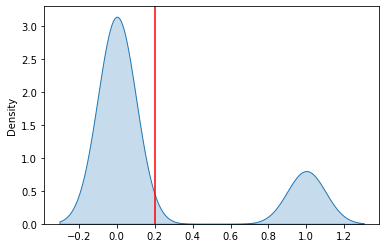

In [35]:
plot_class()

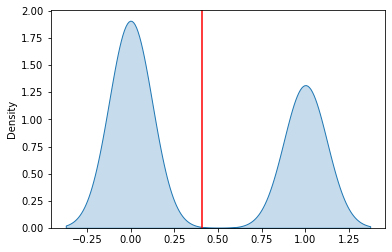

In [36]:
plot_class(0, 1)